In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.enums import *

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 64
dim = 1
kernel = KernelType.Wendland4
targetNeighbors = n_h_to_nH(4, dim)
CFL = 0.3
goalRadius = 0.8

nx = 256
rho0 = 1
E0 = 1
gamma = 1.4

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.OwenScheme

domain = buildDomainDescription(l = 1, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([-1], device = device, dtype = dtype)
domain.max = torch.tensor([1], device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [3]:
import numpy as np
# Function to sample particles such that their density equals a desired PDF
def samplePDF(pdf, n = 2048, numParticles = 256, plot = False, randomSampling = False):
    x = np.linspace(-1,1,n)
    if plot:
        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

    n = 2048
    xs = np.linspace(-1,1,n)

    if plot:
        axis[0,0].plot(xs, pdf(xs))

    normalized_pdf = lambda x: pdf(x) / np.sum(pdf(np.linspace(-1,1,n)))
    if plot:
        axis[0,0].plot(xs, normalized_pdf(xs))
        axis[0,0].axhline(0,ls= '--', color = 'black')


    xs = np.linspace(-1,1,n)
    fxs = normalized_pdf(xs)
    sampled_cdf = np.cumsum(fxs) - fxs[0]
    sampled_cdf = sampled_cdf / sampled_cdf[-1] 
    inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

    samples = np.random.uniform(size = numParticles)
    if not randomSampling:
        samples = np.linspace(0,1,numParticles, endpoint=False)
    sampled = inv_cdf(samples)

    return sampled

In [4]:
noiseDataset = torch.load('noiseDataset.pt')
print(noiseDataset[0]['noise'].shape)

(1024,)


In [5]:
seeds = list(set([data['seed'] for data in noiseDataset]))
baseFrequencies = sorted(list(set([data['baseFrequency'] for data in noiseDataset])))
octaves = sorted(list(set([data['octaves'] for data in noiseDataset])))
persistences = sorted(list(set([data['persistence'] for data in noiseDataset])))
radii = sorted(list(set([data['r'] for data in noiseDataset])))

print(f'Dataset contains: {len(seeds)} seeds, {len(baseFrequencies)} base frequencies, {len(octaves)} octaves, {len(persistences)} persistences and {len(radii)} radii')
print(f'Base Frequencies: {baseFrequencies}')
print(f'Octaves: {octaves}')
print(f'Persistences: {persistences}')
print(f'Radii: {radii}')

Dataset contains: 16 seeds, 4 base frequencies, 4 octaves, 4 persistences and 4 radii
Base Frequencies: [1, 2, 4, 8]
Octaves: [1, 2, 4, 8]
Persistences: [0.125, 0.25, 0.5, 0.75]
Radii: [0.125, 0.25, 0.5, 0.75]


In [6]:
selectedFrequencies = [baseFrequencies[0]]
selectedOctaves = [octaves[2]]
selectedPersistences = [persistences[2]]
selectedRadii = [radii[2]]
selectedSeeds = seeds

selectedData = []
for data in noiseDataset:
    if data['baseFrequency'] in selectedFrequencies and data['octaves'] in selectedOctaves and data['persistence'] in selectedPersistences and data['r'] in selectedRadii and data['seed'] in selectedSeeds:
        selectedData.append(data)
print(f'Selected {len(selectedData)} data points')

Selected 16 data points


In [7]:
selectedNoise = selectedData[0]

noiseField = selectedNoise['noise']
# rescale to -1, 1
noiseField = (noiseField - noiseField.min()) / (noiseField.max() - noiseField.min())
noiseField = noiseField * 0.5 + 1

# noiseField[:] = 1
pdf = lambda x : np.interp(x, np.linspace(-1,1,selectedNoise['noise'].shape[0]), noiseField)

In [8]:
from sphMath.util import volumeToSupport
from sphMath.sampling import ParticleSet

positions = torch.tensor(samplePDF(pdf, n = nx*2, numParticles = nx, plot = False, randomSampling = False), device = device, dtype = dtype).view(-1,1)
masses = torch.ones_like(positions[:,0]) * (domain.max - domain.min)[0]/positions.shape[0] 
densities = torch.tensor(pdf(positions[:,0].cpu().numpy()), device = device, dtype = dtype)
supports = volumeToSupport(masses, targetNeighbors, 1)

particles_l = ParticleSet(positions, supports, masses, densities)


In [9]:
from sphMath.schemes.states.common import BasicState
from sphMath.schemes.states.compressiblesph import CompressibleState

particles = CompressibleState(
    positions = positions,
    supports = supports,
    velocities = torch.zeros_like(positions),
    densities = densities,
    masses = masses,

    kinds = torch.zeros_like(positions[:,0], dtype = torch.int64),
    materials = torch.zeros_like(positions[:,0], dtype = torch.int64),
    UIDs = torch.arange(0, positions.shape[0], device = device, dtype = torch.int64),
    UIDcounter= positions.shape[0],

    soundspeeds= torch.ones_like(positions[:,0]),
    internalEnergies= torch.ones_like(positions[:,0]),
    pressures= torch.ones_like(positions[:,0]),
    totalEnergies=None,
    entropies=None
)

particles.positions += torch.randn_like(particles.positions) * 0.01 * particles.supports.view(-1,1)

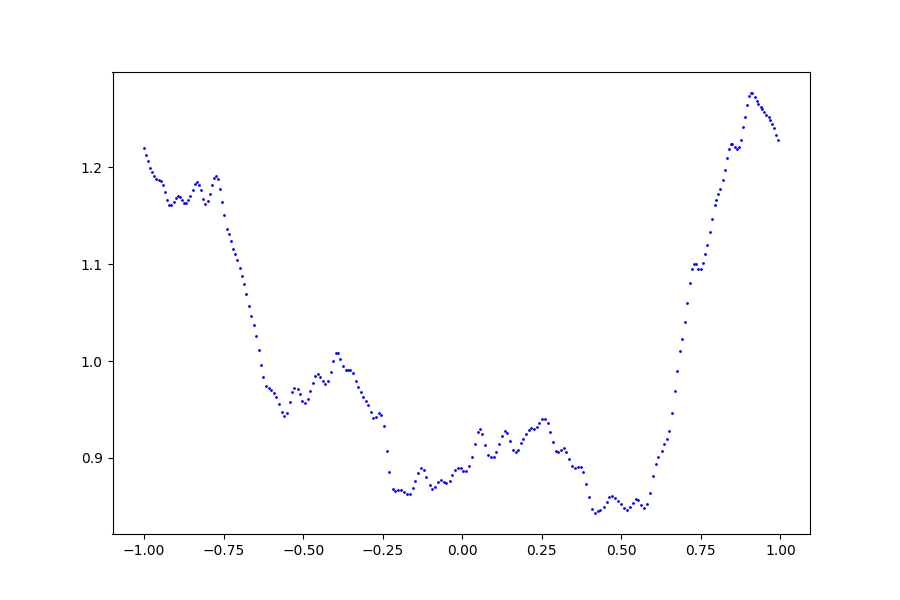

In [10]:
from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, coo_to_csr, SupportScheme

neighborhood = None
neighborhood, neighbors = evaluateNeighborhood(particles, domain, kernel, verletScale = solverConfig['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries

from sphMath.modules.density import computeDensity
from sphMath.modules.CRKSPH import computeCRKVolume

particles.densities = computeDensity(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, solverConfig)
particles.apparentArea = computeCRKVolume(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, solverConfig)

fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].scatter(particles.positions[:,0].cpu().numpy(), particles.densities.cpu().numpy(), s = 1, c = 'blue', label = 'Density')

In [11]:
def f(x):
    # return x**2
    return torch.sin(np.pi * x)
    # return torch.exp(-x**2)

In [12]:

from ml import evalBasisFunction

In [13]:
terms = 6
numFunctions = 32

randomTerms = [(torch.rand(terms, device = device, dtype = dtype)*2-1) * torch.exp(-torch.arange(0, terms, device = device, dtype = dtype) / 4) for i in range(numFunctions)]

print(randomTerms[0].shape[0])

def cheb_fn(x, c):
    return torch.einsum('nb, b -> n', evalBasisFunction(c.shape[0], x, 'chebyshev').mT, c)

@torch.jit.script
def fourier_fn(x: torch.Tensor, c: torch.Tensor):
    return torch.einsum('nb, b -> n', evalBasisFunction(c.shape[0], x, 'ffourier').mT, c)

functions = []
for i in range(len(randomTerms)):
    functions.append(lambda x, i=i: fourier_fn(x, randomTerms[i]))

6


In [14]:
x = particles.positions[:,0].clone()
print(functions[0](x))

tensor([-0.1978, -0.1948, -0.1915, -0.1880, -0.1856, -0.1826, -0.1800, -0.1771,
        -0.1748, -0.1730, -0.1709, -0.1688, -0.1669, -0.1652, -0.1635, -0.1620,
        -0.1606, -0.1594, -0.1581, -0.1567, -0.1556, -0.1543, -0.1532, -0.1519,
        -0.1507, -0.1494, -0.1481, -0.1470, -0.1454, -0.1437, -0.1417, -0.1401,
        -0.1382, -0.1361, -0.1336, -0.1316, -0.1290, -0.1262, -0.1233, -0.1189,
        -0.1163, -0.1126, -0.1076, -0.1036, -0.0992, -0.0941, -0.0879, -0.0833,
        -0.0778, -0.0707, -0.0641, -0.0572, -0.0504, -0.0429, -0.0349, -0.0269,
        -0.0172, -0.0085, -0.0015,  0.0097,  0.0179,  0.0268,  0.0362,  0.0458,
         0.0549,  0.0652,  0.0735,  0.0803,  0.0907,  0.0967,  0.1048,  0.1132,
         0.1195,  0.1260,  0.1318,  0.1372,  0.1416,  0.1457,  0.1491,  0.1521,
         0.1543,  0.1558,  0.1565,  0.1565,  0.1560,  0.1547,  0.1525,  0.1493,
         0.1456,  0.1414,  0.1370,  0.1300,  0.1233,  0.1161,  0.1091,  0.0967,
         0.0889,  0.0798,  0.0676,  0.05

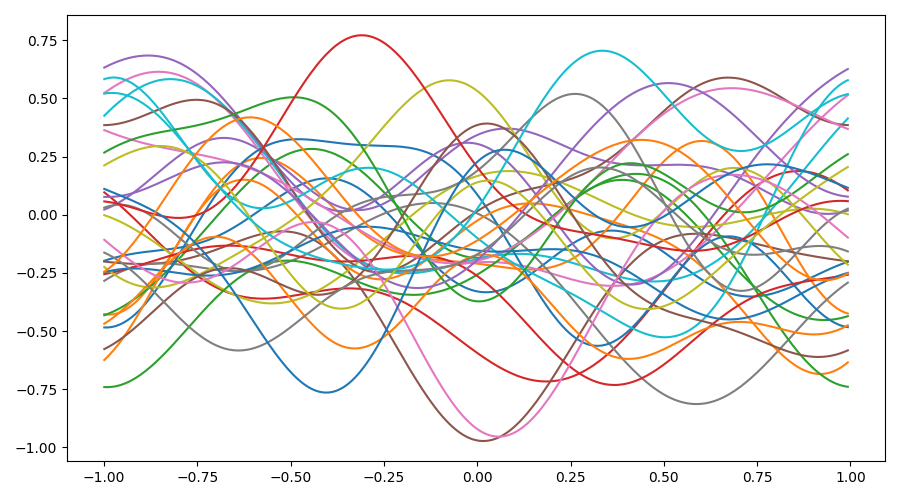

In [15]:
fig, axis = plt.subplots(1, 1, figsize=(9,5), sharex = True, sharey = False, squeeze = False)
for i in range(len(functions)):
    fx = functions[i](particles.positions[:,0])
    axis[0,0].plot(particles.positions[:,0].cpu().numpy(), fx.detach().cpu().numpy(), label = f'f{"" if i==0 else "".join(["-"]*(i))}(x)'.replace('-',"'"), alpha = 1)

fig.tight_layout()

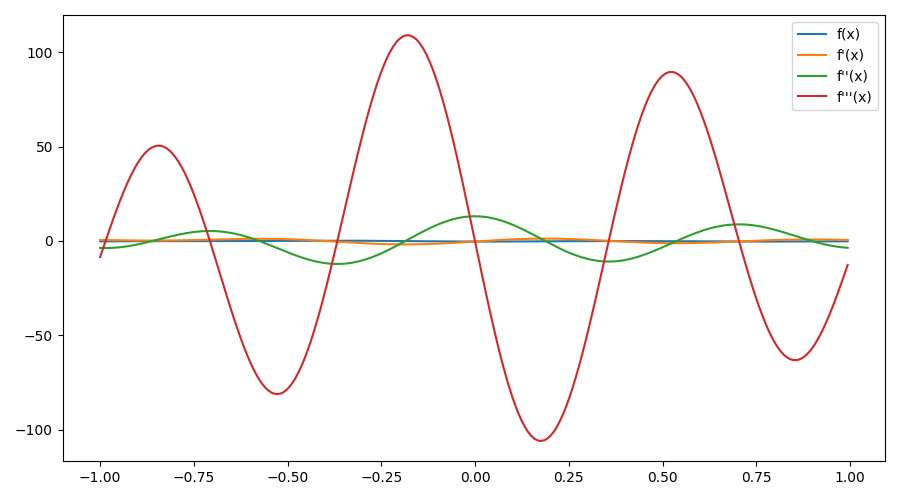

In [16]:
from sphMath.gradientUtil import eval_fn_grad

orders = 3
x = particles.positions[:,0].clone()
x.requires_grad = True
fx = eval_fn_grad(lambda x: functions[0](x), x, orders)

fig, axis = plt.subplots(1, 1, figsize=(9,5), sharex = True, sharey = False, squeeze = False)

for i in range(orders+1):
    axis[0,0].plot(particles.positions[:,0].cpu().numpy(), fx[i].detach().cpu().numpy(), label = f'f{"" if i==0 else "".join(["-"]*(i))}(x)'.replace('-',"'"), alpha = 1)

axis[0,0].legend()

fig.tight_layout()

In [184]:
from ml import *
from sphMath.sphOperations.shared import scatter_sum

class ScatterSumLayer(nn.Module):
    def __init__(self):
        super(ScatterSumLayer, self).__init__()
    def forward(self, input, index, dim, dim_size):
        return scatter_sum(input, index, dim=dim, dim_size=dim_size)
    
def runMLP_(mlp : torch.nn.Module, features : torch.Tensor, batches : int, verbose : bool = False):  
    if verbose:
        print(f'MLP {features.shape} -> {mlp[-1].out_features} features')
    transposedFeatures = features.view(batches,-1, *features.shape[1:])
    
    processedFeatures = mlp(transposedFeatures)
    processedFeatures = processedFeatures.view(-1, *processedFeatures.shape[2:])
    if verbose:
        print(f'\tFeatures: {processedFeatures.shape} [min: {torch.min(processedFeatures)}, max: {torch.max(processedFeatures)}, mean: {torch.mean(processedFeatures)}]')
    return processedFeatures
class SimpleGNN(torch.nn.Module):
    def __init__(self, hyperParameterDict):
        super(SimpleGNN, self).__init__()
            
        self.edgeMLP1 = buildMLPwDict({
            'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
            'inputFeatures': hyperParameterDict['edgeFeatures'] + hyperParameterDict['coordinateFeatures'],
            'output': hyperParameterDict['nodeFeatures'],
            'preNorm': False,
            'norm': False,
            # 'channels': [1],
            'activation': hyperParameterDict['activation'],
            'gain': hyperParameterDict['gain'],
        })
        self.activationLayer = getActivationLayer(hyperParameterDict['activation'])
        self.ScatterSumLayer = ScatterSumLayer()

        numFeatures = hyperParameterDict['nodeFeatures']*2 + hyperParameterDict['edgeFeatures'] + hyperParameterDict['coordinateFeatures'] + hyperParameterDict['featureSize']*2
        messagePassingVertexLayers = []
        messagePassingEdgeLayers = []
        for layer in range(hyperParameterDict['messagePassingLayers']):
            vertexMLP = buildMLPwDict({
                'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
                'inputFeatures': hyperParameterDict['nodeFeatures'],
                'output': hyperParameterDict['nodeFeatures'],
                'preNorm': False,
                'norm': False,
                # 'channels': [1],
                'activation': hyperParameterDict['activation'],
                'gain': 1,
            })
            edgeMLP = buildMLPwDict({
                'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
                'inputFeatures': numFeatures,
                'output': 1 if layer == hyperParameterDict['messagePassingLayers'] - 1 and not hyperParameterDict['finalVertexMLP'] else hyperParameterDict['nodeFeatures'],
                'preNorm': False,
                'norm': False,
                'activation': hyperParameterDict['activation'],
                'gain': hyperParameterDict['gain'],
            })
            messagePassingVertexLayers.append(vertexMLP)
            messagePassingEdgeLayers.append(edgeMLP)

        self.messagePassingVertexLayers = torch.nn.ModuleList(messagePassingVertexLayers)
        self.messagePassingEdgeLayers = torch.nn.ModuleList(messagePassingEdgeLayers)
        self.hyperParameterDict = hyperParameterDict

        if hyperParameterDict['finalVertexMLP'] == True:
            self.finalVertexMLP = buildMLPwDict({
                'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
                'inputFeatures': hyperParameterDict['nodeFeatures'],
                'output': 1,
                'preNorm': False,
                'norm': False,
                # 'channels': [1],
                'activation': hyperParameterDict['activation'],
                'gain': 1,
            })
        else:
            self.finalVertexMLP = None

    def forward(self, particles, neighbors, quantity):
        i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
        hij = (particles.supports[i] + particles.supports[j]) / 2
        encodedDistances = basisEncoderLayer(
            neighbors.get('noghost')[1].x_ij/ hij.view(-1, 1),
            self.hyperParameterDict['basisTerms'], 
            self.hyperParameterDict['basis'],
            self.hyperParameterDict['encoderMode']
        )
        edge_features = torch.cat([
            encodedDistances ,
            particles.masses[i].view(-1, 1),
            particles.masses[j].view(-1, 1),
            particles.supports[i].view(-1, 1),
            particles.supports[j].view(-1, 1),
        ], dim = -1)

        processedEdges = runMLP_(self.edgeMLP1, edge_features,1, verbose = False) * (particles.masses[j] / particles.densities[j]).view(-1, 1)

        aggregatedEdges = scatter_sum(processedEdges, i, dim = 0, dim_size = particles.positions.shape[0])
        for layer in range(self.hyperParameterDict['messagePassingLayers']):
            vertexFeatures = runMLP_(self.messagePassingVertexLayers[layer], aggregatedEdges, 1, verbose = False)
            vertexFeatures = self.activationLayer(vertexFeatures)

            newFeatures = torch.cat([
                vertexFeatures,
                particles.masses.view(-1, 1),
                particles.supports.view(-1, 1),
                quantity.view(-1, 1),
            ], dim = -1)
            v_j = newFeatures[j]
            v_i = newFeatures[i]

            v_ij = torch.cat([v_i, v_j, encodedDistances / hij.view(-1, 1)], dim = -1)

            processedEdges = runMLP_(self.messagePassingEdgeLayers[layer], v_ij, 1, verbose = False) * (particles.masses[j] / particles.densities[j]).view(-1, 1)
            aggregatedEdges = scatter_sum(processedEdges, i, dim = 0, dim_size = particles.positions.shape[0])

        if self.finalVertexMLP is not None:
            vertexFeatures = runMLP_(self.finalVertexMLP, aggregatedEdges, 1, verbose = False)
            # vertexFeatures = self.activationLayer(vertexFeatures)
        else:
            vertexFeatures = aggregatedEdges
            
        return vertexFeatures[:,0]
        # return scatter_sum(term, i, dim = 0, dim_size = particles.positions.shape[0])[:,0]



In [185]:

from sphMath.util import volumeToSupport
from sphMath.sampling import ParticleSet
from sphMath.schemes.states.common import BasicState
from sphMath.schemes.states.compressiblesph import CompressibleState
from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, coo_to_csr, SupportScheme
from sphMath.modules.density import computeDensity
from sphMath.modules.CRKSPH import computeCRKVolume

def loadData(dataset, entry, densityMean = 1.0, densityMagnitude = 0.5, noiseMagnitude = 0.0):
    selectedNoise = dataset[entry]

    noiseField = selectedNoise['noise']
    # rescale to -1, 1
    noiseField = (noiseField - noiseField.min()) / (noiseField.max() - noiseField.min())
    noiseField = noiseField * densityMagnitude + densityMean

    # noiseField[:] = 1
    pdf = lambda x : np.interp(x, np.linspace(-1,1,selectedNoise['noise'].shape[0]), noiseField)

    positions = torch.tensor(samplePDF(pdf, n = nx*2, numParticles = nx, plot = False, randomSampling = False), device = device, dtype = dtype).view(-1,1)
    masses = torch.ones_like(positions[:,0]) * (domain.max - domain.min)[0]/positions.shape[0] 
    densities = torch.tensor(pdf(positions[:,0].cpu().numpy()), device = device, dtype = dtype)
    supports = volumeToSupport(masses, targetNeighbors, 1)

    particles_l = ParticleSet(positions, supports, masses, densities)

    particles = CompressibleState(
        positions = positions,
        supports = supports,
        velocities = torch.zeros_like(positions),
        densities = densities,
        masses = masses,

        kinds = torch.zeros_like(positions[:,0], dtype = torch.int64),
        materials = torch.zeros_like(positions[:,0], dtype = torch.int64),
        UIDs = torch.arange(0, positions.shape[0], device = device, dtype = torch.int64),
        UIDcounter= positions.shape[0],

        soundspeeds= torch.ones_like(positions[:,0]),
        internalEnergies= torch.ones_like(positions[:,0]),
        pressures= torch.ones_like(positions[:,0]),
        totalEnergies=None,
        entropies=None
    )

    particles.positions += torch.randn_like(particles.positions) * noiseMagnitude * particles.supports.view(-1,1)


    neighborhood = None
    neighborhood, neighbors = evaluateNeighborhood(particles, domain, kernel, verletScale = solverConfig['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
    particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries


    particles.densities = computeDensity(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, solverConfig)
    particles.apparentArea = computeCRKVolume(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, solverConfig)

    return particles, neighborhood, neighbors

from sphMath.operations import SPHOperation, Operation, GradientMode, LaplacianMode
from sphMath.enums import *
def computeSPHDerivative(particles, neighbors, fi, targetOrder = 0):
    i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
    hMax = particles.supports.max()
    positions = particles.positions
    targetOrder = targetOrder

    interpolated = SPHOperation(
        particles,
        quantity = fi,
        kernel = kernel,
        neighborhood = neighbors.get('noghost')[0],
        kernelValues = neighbors.get('noghost')[1],
        operation = Operation.Interpolate,
        gradientMode = GradientMode.Difference,
        laplacianMode = LaplacianMode.naive,
    )
    if targetOrder == 0:
        return interpolated
    else:
        for i in range(targetOrder):
            interpolated = SPHOperation(
                particles,
                quantity = interpolated,
                kernel = kernel,
                neighborhood = neighbors.get('noghost')[0],
                kernelValues = neighbors.get('noghost')[1],
                operation = Operation.Gradient,
                gradientMode = GradientMode.Difference,
                laplacianMode = LaplacianMode.naive,
            )[:,0]
        return interpolated



In [186]:
noiseMagnitude = 0.0
densityMean = 1.0
densityMagnitude = 0.5

preloadedData = []
for i in tqdm(range(len(selectedData))):
    particles, neighborhood, neighbors = loadData(selectedData, i, densityMean = densityMean, densityMagnitude = densityMagnitude, noiseMagnitude = noiseMagnitude)
    preloadedData.append((particles, neighborhood, neighbors))

  0%|          | 0/16 [00:00<?, ?it/s]

In [216]:

basisTerms = 4
hiddenLayers = 2
hiddenUnits = 64
nodeFeatures = 8
activation = 'gelu'

additionalEdgeFeatures = 4 # v_i, v_j, h_i, h_j

neighbors.get('noghost')[1].x_ij

encodedDistances = basisEncoderLayer(
    neighbors.get('noghost')[1].x_ij,
    basisTerms, 
    'ffourier',
    'cat'
)
GNN = SimpleGNN({
    'hiddenLayers': hiddenLayers,
    'hiddenUnits': hiddenUnits,
    'edgeFeatures': additionalEdgeFeatures,
    'coordinateFeatures': encodedDistances.shape[1],
    'nodeFeatures': nodeFeatures,
    'featureSize': 1,
    'activation': activation,
    'basisTerms': basisTerms,
    'basis': 'ffourier',
    'encoderMode': 'cat',
    'gain': 1/100,
    'messagePassingLayers': 2,
    'finalVertexMLP': True,
}).to(device)


optimizer = torch.optim.Adam(GNN.parameters(), lr=1e-2)
learningRateScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.75)

In [217]:

numParameters = 0
for param in GNN.parameters():
    numParameters += param.numel()
print(f'GNN has {numParameters} parameters')

fi_nn = GNN(particles, neighbors, fx[0].detach())
print(fi_nn.shape)

GNN has 33385 parameters
torch.Size([256])


In [218]:
i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
hMax = particles.supports.max()
positions = particles.positions
targetOrder = 2

trainIterations = 2**12
losses = []
predictions = []
psnr_values = []
psnr_sph_values = []

for ii in (t := tqdm(range(trainIterations))):
    dataIndex = torch.randint(0, len(preloadedData), (1,)).item()
    functionIndex = torch.randint(0, len(functions), (1,)).item()
    # dataIndex = 0
    batchlosses = []
    psrns = []
    psnrs_sph = []
    # functionIndex = 0
    for functionIndex in range(len(functions)):        
        particles, neighborhood, neighbors = preloadedData[dataIndex]
        x = particles.positions[:,0].clone()
        f_max = torch.max(torch.abs(functions[functionIndex](x)))

        x.requires_grad = True
        fx = eval_fn_grad(lambda x: functions[functionIndex](x) / f_max, x, targetOrder+1)

        optimizer.zero_grad()
        fi_nn = GNN(particles, neighbors, fx[0].detach())
        # fi_nn = scatter_sum(W_nn * fx[0][j].detach() * particles.masses[j] / particles.densities[j], i, dim = 0, dim_size = particles.positions.shape[0])
        error = fi_nn - fx[targetOrder].detach().flatten()
        error = torch.where(torch.logical_and(positions > -1 + 1.5 * hMax, positions < 1 - 1.5 * hMax), error, torch.zeros_like(error))
        loss = torch.sum(error**2)

        maxMagnitude = torch.max(torch.abs(fx[targetOrder].detach().flatten()))
        MSE = torch.mean(error**2)
        psnr = 10 * torch.log10(maxMagnitude**2 / MSE)
        psrns.append(psnr)
        batchlosses.append(loss)
        fi_sph = computeSPHDerivative(particles, neighbors, fx[0].flatten(), targetOrder = targetOrder)
        sph_error = fi_sph - fx[targetOrder].detach().flatten()
        MSE_SPH = torch.mean(sph_error**2)
        psnr_sph = 10 * torch.log10(maxMagnitude**2 / MSE_SPH)
        psnrs_sph.append(psnr_sph)

        # batchlosses.append(psnr)
    loss = torch.mean(torch.stack(batchlosses))
    psnr = torch.mean(torch.stack(psrns))
    psnr_sph = torch.mean(torch.stack(psnrs_sph))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    psnr_values.append(psnr.item())
    psnr_sph_values.append(psnr_sph.item())

    predictions.append(fi_nn.detach().cpu().numpy())
    t.set_postfix(loss=loss.item(), psnr=psnr.item(), lr = learningRateScheduler.get_last_lr()[0], psnr_sph = psnr_sph.item())
    learningRateScheduler.step()

  0%|          | 0/4096 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [214]:
i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
hMax = particles.supports.max()
positions = particles.positions
targetOrder = 2

trainIterations = 2**12
losses = []
predictions = []
psnr_values = []
psnr_sph_values = []

for ii in (t := tqdm(range(trainIterations))):
    dataIndex = torch.randint(0, len(preloadedData), (1,)).item()
    functionIndex = torch.randint(0, len(functions), (1,)).item()
    # dataIndex = 0
    batchlosses = []
    psrns = []
    psnrs_sph = []
    functionIndex = 0
    for dataIndex in range(len(preloadedData)):        
        particles, neighborhood, neighbors = preloadedData[dataIndex]
        x = particles.positions[:,0].clone()
        x.requires_grad = True
        fx = eval_fn_grad(lambda x: functions[functionIndex](x), x, targetOrder+1)

        optimizer.zero_grad()
        fi_nn = GNN(particles, neighbors, fx[0].detach())
        # fi_nn = scatter_sum(W_nn * fx[0][j].detach() * particles.masses[j] / particles.densities[j], i, dim = 0, dim_size = particles.positions.shape[0])
        error = fi_nn - fx[targetOrder].detach().flatten()
        error = torch.where(torch.logical_and(positions > -1 + 1.5 * hMax, positions < 1 - 1.5 * hMax), error, torch.zeros_like(error))
        loss = torch.sum(error**2)

        maxMagnitude = torch.max(torch.abs(fx[targetOrder].detach().flatten()))
        MSE = torch.mean(error**2)
        psnr = 10 * torch.log10(maxMagnitude**2 / MSE)
        psrns.append(psnr)
        batchlosses.append(loss)
        fi_sph = computeSPHDerivative(particles, neighbors, fx[0].flatten(), targetOrder = targetOrder)
        sph_error = fi_sph - fx[targetOrder].detach().flatten()
        MSE_SPH = torch.mean(sph_error**2)
        psnr_sph = 10 * torch.log10(maxMagnitude**2 / MSE_SPH)
        psnrs_sph.append(psnr_sph)

        # batchlosses.append(psnr)
    loss = torch.mean(torch.stack(batchlosses))
    psnr = torch.mean(torch.stack(psrns))
    psnr_sph = torch.mean(torch.stack(psnrs_sph))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    psnr_values.append(psnr.item())
    psnr_sph_values.append(psnr_sph.item())

    predictions.append(fi_nn.detach().cpu().numpy())
    t.set_postfix(loss=loss.item(), psnr=psnr.item(), lr = learningRateScheduler.get_last_lr()[0], psnr_sph = psnr_sph.item())
    learningRateScheduler.step()

  0%|          | 0/4096 [00:00<?, ?it/s]

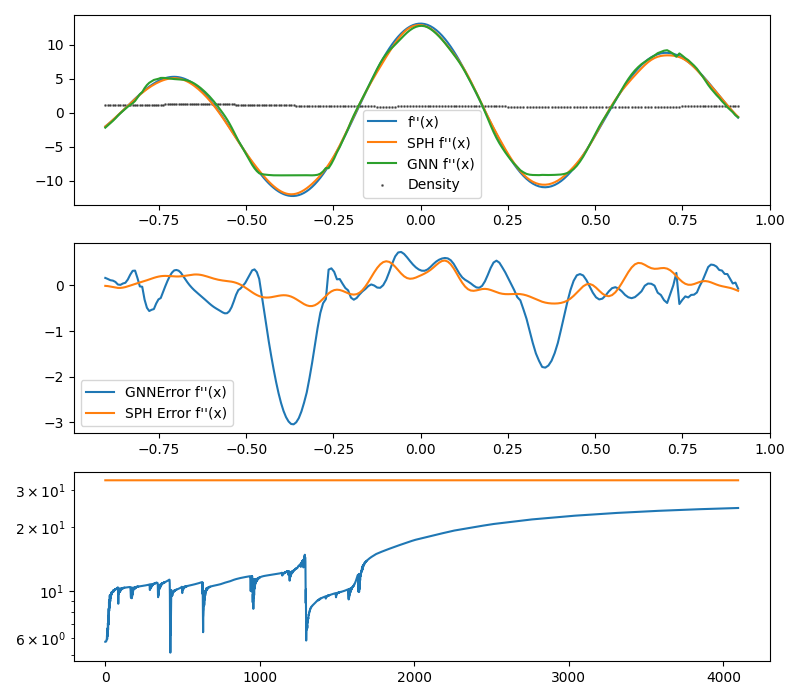

In [215]:

fig, axis = plt.subplots(3, 1, figsize=(8, 7), squeeze=False)

W_nn = GNN(particles, neighbors, fx[0].detach())
# fi_nn = scatter_sum(W_nn * fx[0][j].detach() * particles.masses[j] / particles.densities[j], i, dim = 0, dim_size = particles.positions.shape[0])
fi_sph = computeSPHDerivative(particles, neighbors, fx[0].flatten(), targetOrder = targetOrder)

fi_target = fx[targetOrder].detach()
difference = fi_target - fi_nn
difference_sph = fi_target - fi_sph

mask = torch.logical_and(positions > -1 + 1.5 * hMax, positions < 1 - 1.5 * hMax)[:,0]
# print(mask)
axis[0,0].plot(particles.positions[mask,0].cpu().detach().numpy(), fi_target[mask].detach().cpu().numpy(), label = f'f{"" if targetOrder==0 else "".join(["-"]*(targetOrder))}(x)'.replace('-',"'"), alpha = 1)
axis[0,0].plot(particles.positions[mask,0].cpu().detach().numpy(), fi_sph[mask].detach().cpu().numpy(), label = f'SPH f{"" if targetOrder==0 else "".join(["-"]*(targetOrder))}(x)'.replace('-',"'"), alpha = 1)
axis[0,0].plot(particles.positions[mask,0].cpu().detach().numpy(), fi_nn[mask].detach().cpu().numpy(), label = f'GNN f{"" if targetOrder==0 else "".join(["-"]*(targetOrder))}(x)'.replace('-',"'"), alpha = 1)

axis[0,0].scatter(particles.positions[mask,0].cpu().detach().numpy(), particles.densities[mask].cpu().detach().numpy(), s = 1, c = 'black', label = 'Density', alpha = 0.5)

axis[1,0].plot(particles.positions[mask,0].cpu().detach().numpy(), difference[mask].detach().cpu().numpy(), label = f'GNNError f{"" if targetOrder==0 else "".join(["-"]*(targetOrder))}(x)'.replace('-',"'"), alpha = 1)
axis[1,0].plot(particles.positions[mask,0].cpu().detach().numpy(), difference_sph[mask].detach().cpu().numpy(), label = f'SPH Error f{"" if targetOrder==0 else "".join(["-"]*(targetOrder))}(x)'.replace('-',"'"), alpha = 1)
axis[0,0].legend()
axis[1,0].legend()

axis[2,0].plot(psnr_values, label = 'Loss')
axis[2,0].plot(psnr_sph_values, label = 'Loss SPH')
axis[2,0].set_yscale('log')

fig.tight_layout()